In [39]:
from dotenv import load_dotenv

import os

import pandas as pd
from openai import OpenAI

import openai

In [53]:
load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_KEY

In [54]:
client = OpenAI()

In [57]:
model_lst = openai.models
print(model_lst.list())

SyncPage[Model](data=[Model(id='gpt-3.5-turbo-0301', created=1677649963, object='model', owned_by='openai'), Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-0125', created=1706048358, object='model', owned_by='system'), Model(id='text-embedding-ada-002', created=1671217299, object='model', owned_by='openai-internal'), Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'), Model(id='tts-1-hd-1106', created=1699053533, object='model', owned_by='system'), Model(id='tts-1-hd', created=1699046015, object='model', owned_by='system'), Model(id='davinci-002', created=1692634301, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-16k-0613', created=1685474247, object='model', owned_by='openai'), Model(id='text-embedding-3-large', created=1705953180

In [4]:
# dump the list in text file
with open("model_list.txt", "w") as f:
    f.write(str(model_lst.list()))

In [40]:
df = pd.read_csv("/Users/Yasser/Projects/masters_thesis/Master_Thesis/data/argument_relation_class.csv")
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",1
1,"So we continue to build for high AFN, or Amazo...",1
2,"On tech and content, that's going to be a comb...",0
3,And what you'll see is that basically people u...,0
4,Our goal really is to kick-start an ecosystem ...,0
...,...,...
9793,I actually think over the next couple of years...,0
9794,"That said, I don't think it’s growing as fast ...",1
9795,So I think you do see some interplay there on ...,1
9796,"There they're really two key dynamics, the fir...",1


In [41]:
# map labels 1 to Related and 0 to Unrelated
df["label"] = df["label"].map({1: "Related", 0: "Unrelated"})
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",Related
1,"So we continue to build for high AFN, or Amazo...",Related
2,"On tech and content, that's going to be a comb...",Unrelated
3,And what you'll see is that basically people u...,Unrelated
4,Our goal really is to kick-start an ecosystem ...,Unrelated
...,...,...
9793,I actually think over the next couple of years...,Unrelated
9794,"That said, I don't think it’s growing as fast ...",Related
9795,So I think you do see some interplay there on ...,Related
9796,"There they're really two key dynamics, the fir...",Related


In [42]:
# Generate 2 cols by split text column into claim and permise, please note separator is [SEP] then remove [SEP] from premise
df[["claim", "premise"]] = df["text"].str.split("\[SEP\]", n=1, expand=True)
df

,text,label,claim,premise
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries..."
...,...,...,...,...
9793,I actually think over the next couple of years...,Unrelated,I actually think over the next couple of years...,We certainly have additional delivery capabil...
9794,"That said, I don't think it’s growing as fast ...",Related,"That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,..."
9795,So I think you do see some interplay there on ...,Related,So I think you do see some interplay there on ...,"That means more time in video, and that does ..."
9796,"There they're really two key dynamics, the fir...",Related,"There they're really two key dynamics, the fir...",The component that actually has impacted -- t...


In [64]:
sample = df.sample(3)
sample

,text,label,claim,premise
5882,There are two broad sets of improvements that ...,Related,There are two broad sets of improvements that ...,One are to the capture and sharing tools that...
1262,And so when we look at all these things in its...,Unrelated,And so when we look at all these things in its...,So what we've seen – we've done some research...
2997,"But overall, the way we have thought about it ...",Related,"But overall, the way we have thought about it ...","Because increasingly, there will be more devi..."


## Modelling

In [101]:
#TODO: Create a function to generate the messages for argument clause relation classification by explaining the task and providing the claim and premise as this:

def generate_messages(claim, premise):
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Given the following claim and premise, please classify the relation between them as either Related or Unrelated. Please only generate one of the two labels."},
        {"role": "user", "content": f"Claim: {claim}"},
        {"role": "user", "content": f"Premise: {premise}"},
    ]
    return messages

In [103]:
function = {
   "name": "predict_premise_claim_relation",
   "description": "Predict the relation between a claim and a premise.",
   "parameters": {
       "type": "object",
       "properties": {
           "prediction": {
               "type": "array",
               "items": {
                   "type": "string",
                   "enum": [
                       "Related",
                       "Unrelated"
                   ]
               },
               "description": "The predicted relation between the claim and the premise."
           }
       },
       "required": [
           "prediction"
       ]
   }
}

In [104]:
#TODO: Use the generated prompt to generate the completion using openai's GPT-4 model, please use chat completions
def generate_completions(messages, model="gpt-4"):
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        functions=[function],
        temperature=0.0,
        seed=42,
    )
    return completion


In [120]:
#TODO: Use the generated completion to predict the relation between the claim and the premise    
def predict_relation(claim, premise, model="gpt-4"):
    try:
        prompt = generate_messages(claim, premise)
        completion = generate_completions(prompt, model)
        print(completion.choices[0].message.content)
        return (completion.choices[0].message.content, completion)
    except Exception as e:
        print(e)
        return ("Unrelated", completion)
    

### Dangerous Don't Run!!!

In [121]:
#TODO: Use the predict_relation function to predict the relation between the claim and the premise for the sample then generate a column in df called predicted_relation and completion_object
# df["predicted_relation"], df["completion_object"] = zip(*df.apply(lambda x: predict_relation(x["claim"], x["premise"]), axis=1))

Related
None
Unrelated
Unrelated
Unrelated
Related
Related
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Related
Unrelated
Unrelated
Unrelated
Related
Unrelated
None
Unrelated
Unrelated
Unrelated
None
Related
Related
Related
Related
Related
Related
Unrelated
Unrelated
None
Unrelated
Unrelated
Unrelated
None
Related
Unrelated
Unrelated
Related
Related
Unrelated
Related
Unrelated
Unrelated
Unrelated
Unrelated
None
Related
None
Related
Unrelated
None
Unrelated
Related
None
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
None
Related
None
Unrelated
Related
Unrelated
None
Related
Related
Unrelated
Related
Unrelated
Related
None
Unrelated
Related
Related
Unrelated
Unrelated
None
None
None
Unrelated
Unrelated
Unrelated
Related
Related
Related
Related
Related
Unrelated
None
Related
None
Unrelated
Related
Related
None
Related
Unrelated
Unrelated
Related
Unrelated
Unrelated
Unrelated
None
Related
Related
Unrelated
None
Related
Unrelated
None
None
Unrelated
Rel

In [122]:
df.head()

,text,label,claim,premise,predicted_relation,completion_object
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,Related,ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwx...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,None,ChatCompletion(id='chatcmpl-8oZjH8upLekufi7eia...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...,Unrelated,ChatCompletion(id='chatcmpl-8oZjIoWMXFljpz0szh...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...,Unrelated,ChatCompletion(id='chatcmpl-8oZjJKWgfQ4Xn3DbP8...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",Unrelated,ChatCompletion(id='chatcmpl-8oZjKU0cxdV2QyjvEa...


In [123]:
# save the sample to a csv file
df.to_csv("temp_0_seed_42_gpt_4_zero_shot_classification.csv", index=False)

## Experiment Analysis

In [49]:
#TODO: report Marco F1 score, precision, recall, and accuracy and the confusion matrix then save them in a text file
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def report_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred, labels=["Related", "Unrelated"])
    return report, confusion


In [41]:
import pandas as pd

df = pd.read_csv("temp_0_seed_42_gpt_4_zero_shot_classification.csv")
df

,text,label,claim,premise,predicted_relation,completion_object
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,Related,ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwx...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,NaN,ChatCompletion(id='chatcmpl-8oZjH8upLekufi7eia...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...,Unrelated,ChatCompletion(id='chatcmpl-8oZjIoWMXFljpz0szh...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...,Unrelated,ChatCompletion(id='chatcmpl-8oZjJKWgfQ4Xn3DbP8...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",Unrelated,ChatCompletion(id='chatcmpl-8oZjKU0cxdV2QyjvEa...
...,...,...,...,...,...,...
9793,I actually think over the next couple of years...,Unrelated,I actually think over the next couple of years...,We certainly have additional delivery capabil...,Unrelated,ChatCompletion(id='chatcmpl-8ocHs72g8zRNDHQf5Q...
9794,"That said, I don't think it’s growing as fast ...",Related,"That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,...",Unrelated,ChatCompletion(id='chatcmpl-8ocHtfcmhKyZiUhWqd...
9795,So I think you do see some interplay there on ...,Related,So I think you do see some interplay there on ...,"That means more time in video, and that does ...",NaN,ChatCompletion(id='chatcmpl-8ocHt0gnBihOCIzOdj...
9796,"There they're really two key dynamics, the fir...",Related,"There they're really two key dynamics, the fir...",The component that actually has impacted -- t...,Unrelated,ChatCompletion(id='chatcmpl-8ocHvLqw74aZdBP5dO...


In [23]:
# extract completion_tokens and prompt_tokens from str "ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwxEr1msYhyYQd', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Related', role='assistant', function_call=None, tool_calls=None))], created=1707064434, model='gpt-4-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=2, prompt_tokens=155, total_tokens=157))"
def extract_tokens(completion_object):
    completion_tokens = int(completion_object.split("completion_tokens=")[1].split(",")[0])
    prompt_tokens = int(completion_object.split("prompt_tokens=")[1].split(",")[0])
    return completion_tokens, prompt_tokens


df["completion_tokens"], df["prompt_tokens"] = zip(*completion_objects.apply(extract_tokens))

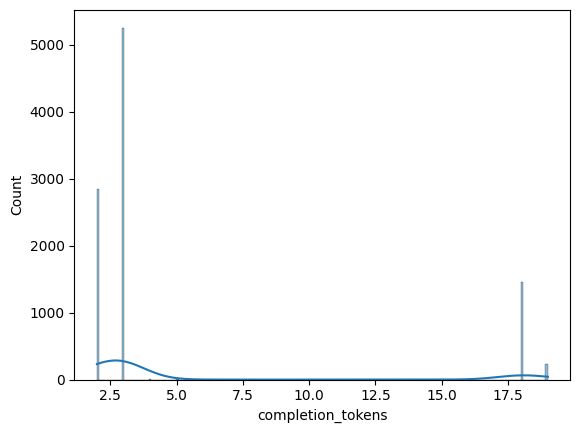

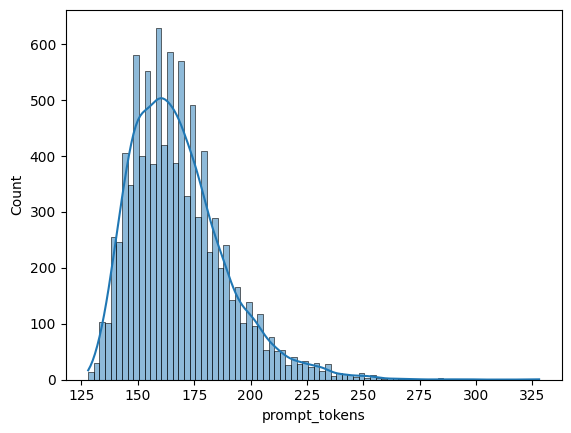

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# draw a distributation for completion_tokens and prompt_tokens
sns.histplot(df["completion_tokens"], kde=True)
plt.show()

sns.histplot(df["prompt_tokens"], kde=True)
plt.show()

In [38]:
df[df["completion_tokens"]>17]['completion_object'].iloc[0]

'ChatCompletion(id=\'chatcmpl-8oZjH8upLekufi7eiawjjfVYJwrRN\', choices=[Choice(finish_reason=\'function_call\', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role=\'assistant\', function_call=FunctionCall(arguments=\'{\\n"prediction": "Related"\\n}\', name=\'predict_premise_claim_relation\'), tool_calls=None))], created=1707064435, model=\'gpt-4-0613\', object=\'chat.completion\', system_fingerprint=None, usage=CompletionUsage(completion_tokens=18, prompt_tokens=171, total_tokens=189))'

In [27]:
# sum count the number of tokens in the completion and prompt and sum the counts
total_completion = df["completion_tokens"].sum()
total_prompt = df["prompt_tokens"].sum()
total_completion, total_prompt

(52053, 1645083)

In [28]:
cost = (0.06 * (total_completion/1000)) + (0.03 * (total_prompt/1000))
cost

52.47567

### Post porcess the predicted_relation

In [46]:
df["predicted_relation"].value_counts()

# map "Unrelated" and "Related" to Unrelated and Related
df["predicted_relation"] = df["predicted_relation"].map({"Unrelated": "Unrelated", "Related": "Related"})

# if Nan then check the completion_object for "Related" or "Unrelated" and then put the value in the predicted_relation
df["predicted_relation"] = df["predicted_relation"].fillna(df["completion_object"].apply(lambda x: "Related" if "Related" in x else "Unrelated"))
df["predicted_relation"].value_counts()

predicted_relation
Unrelated    5486
Related      4312
Name: count, dtype: int64

In [47]:
#TODO: Save the classification report and the confusion matrix in a text file
y_true = df["label"]
y_pred = df["predicted_relation"]

              precision    recall  f1-score   support

     Related       0.85      0.75      0.79      4899
   Unrelated       0.77      0.87      0.82      4899

    accuracy                           0.81      9798
   macro avg       0.81      0.81      0.81      9798
weighted avg       0.81      0.81      0.81      9798





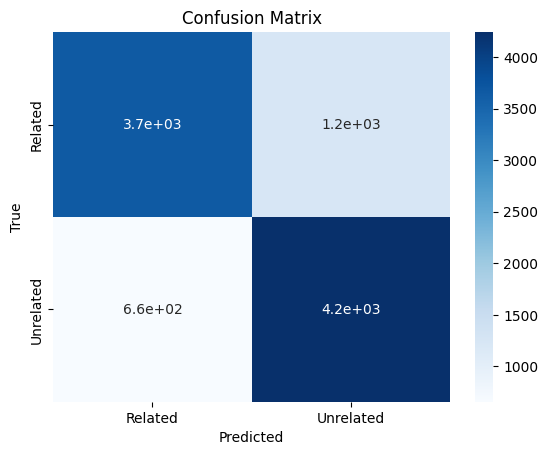

In [50]:
report, confusion = report_metrics(y_true, y_pred)
print(report)
print("\n")

# heatmap for confusion matrix and show classes and save it
sns.heatmap(confusion, annot=True, cmap="Blues", xticklabels=["Related", "Unrelated"], yticklabels=["Related", "Unrelated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("temp_0_seed_42_gpt_4_zero_shot_classification_confusion_matrix.png")
plt.show()


In [51]:
with open("temp_0_seed_42_gpt_4_zero_shot_classification_report.txt", "w") as f:
    f.write(report)

## Few Shot Experiment

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from dotenv import load_dotenv

import os

load_dotenv()


True

In [79]:
import openai
client = openai.OpenAI(
    api_key=os.getenv("OPENAI_KEY"))

response = client.embeddings.create(
    model="text-embedding-3-small",
    input=["Example text here.", "Sdasda"]
)

embedding = response.data[0].embedding

In [80]:
embedding

[-0.01156528852880001,
 -0.004452785477042198,
 -0.020291553810238838,
 -0.003785988548770547,
 -0.024684570729732513,
 -0.025625931099057198,
 0.019604209810495377,
 0.03338095173239708,
 0.037564776837825775,
 0.011647471226751804,
 0.034994710236787796,
 0.016152555122971535,
 0.007747548166662455,
 0.00812110397964716,
 0.052716199308633804,
 0.0710652619600296,
 -0.0014260493917390704,
 0.03825211897492409,
 -0.026642002165317535,
 0.07907430082559586,
 0.016391631215810776,
 0.017631836235523224,
 -0.007874556817114353,
 0.06305622309446335,
 0.0062794736586511135,
 -0.0025794031098484993,
 -0.0027755198534578085,
 0.029854582622647285,
 0.07506978511810303,
 -0.045663464814424515,
 0.018259409815073013,
 -0.0449761226773262,
 0.0011860397644340992,
 -0.04787491634488106,
 -0.01686978153884411,
 0.04174860194325447,
 0.053792040795087814,
 0.03356025740504265,
 -0.0015717361820861697,
 -0.017273223027586937,
 0.013567548245191574,
 -0.02973504550755024,
 0.04285432770848274,
 0.0

### Implement Text Embeddings

In [93]:
# Assuming necessary libraries are already imported and initialized
batch_size = 100  # Define a reasonable batch size

In [94]:
def get_batch_embeddings_and_save(original_text, texts, labels, batch_size, filename='text-embedding-3-small-embeddings.csv'):
    all_data = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        response = client.embeddings.create(
            model="text-embedding-3-small",
            input=batch
        )
        embeddings = [data.embedding for data in response.data]
        all_data.extend(embeddings)
    
    # dont's lose precision for the embeddings 
    df = pd.DataFrame(np.array(all_data), columns=[f"embedding_{i}" for i in range(len(all_data[0]))])
    df["text"] = texts
    df["label"] = labels
    df["original_text"] = original_text
    df.to_csv(filename, index=False)
    return df


In [95]:
def load_embeddings_with_texts(filename='text-embedding-3-small-embeddings.csv'):
    df = pd.read_csv(filename)
    texts = df["text"]
    labels = df["label"]    
    embeddings = df.drop(columns=["text", "label", "original_text"]).values
    return texts, labels, embeddings


#### Similarity To Find Few-Shots

In [96]:
texts = [f"Claim: {row.claim} Premise: {row.premise}" for row in df.itertuples()]
labels = [row.label for row in df.itertuples()]
original_texts = [row.text for row in df.itertuples()]
embedded_texts = get_batch_embeddings_and_save(original_texts,texts, labels, batch_size)
embedded_texts

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,text,label,original_text
0,-0.016876,0.004087,0.029724,0.044046,0.080826,-0.011341,-0.033041,0.041493,0.016863,0.025972,...,0.058184,-0.005460,0.000031,0.009386,-0.015468,-0.001345,0.012716,"Claim: In fact as I said, a lot of the Azure u...",Related,"In fact as I said, a lot of the Azure use case..."
1,0.004163,0.028775,0.049519,0.018570,0.063024,0.008863,-0.022534,0.022099,-0.011689,0.027752,...,-0.020462,0.004799,0.012245,0.000509,0.005886,0.009285,0.014758,"Claim: So we continue to build for high AFN, o...",Related,"So we continue to build for high AFN, or Amazo..."
2,0.047711,-0.002777,0.028159,0.048109,0.072138,-0.007755,0.019005,0.058158,-0.001383,0.009310,...,0.010093,0.028706,0.009465,-0.003722,0.002138,0.006334,0.004409,"Claim: On tech and content, that's going to be...",Unrelated,"On tech and content, that's going to be a comb..."
3,0.044751,0.012101,-0.079011,0.069804,0.061044,0.005566,0.033786,0.035097,0.031191,0.007993,...,0.020980,0.012576,-0.019292,0.003592,0.026741,-0.014815,-0.024468,Claim: And what you'll see is that basically p...,Unrelated,And what you'll see is that basically people u...
4,0.021468,0.024020,-0.030218,0.040107,0.003170,0.016947,0.008371,0.086980,-0.001261,0.019674,...,-0.007084,0.013126,0.009429,0.004437,0.021541,-0.020185,0.000547,Claim: Our goal really is to kick-start an eco...,Unrelated,Our goal really is to kick-start an ecosystem ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,0.014459,0.019580,-0.027968,0.030874,0.043908,0.000504,0.027436,0.045635,0.032831,-0.018401,...,0.018775,0.032658,0.001670,0.008690,0.022501,-0.001431,-0.013941,Claim: I actually think over the next couple o...,Unrelated,I actually think over the next couple of years...
9794,0.014414,0.004470,0.017204,0.050443,0.054906,-0.002329,-0.007973,-0.005258,0.013324,0.001533,...,0.003642,0.009821,0.033758,0.020304,-0.005952,-0.002052,0.002994,"Claim: That said, I don't think it’s growing a...",Related,"That said, I don't think it’s growing as fast ..."
9795,0.006414,0.005942,-0.037633,0.049888,0.049161,0.004987,0.040319,0.040571,0.022566,0.044544,...,0.022132,0.039004,-0.000217,0.013213,0.013836,0.028707,-0.010793,Claim: So I think you do see some interplay th...,Related,So I think you do see some interplay there on ...
9796,-0.030326,0.031239,0.037598,0.014323,0.050282,0.041315,-0.007096,0.054913,0.012138,-0.009383,...,0.022223,0.003100,0.009962,-0.016712,-0.036587,0.010859,0.020886,"Claim: There they're really two key dynamics, ...",Related,"There they're really two key dynamics, the fir..."


In [97]:
texts, labels, embeddings = load_embeddings_with_texts()

In [98]:
labels

0         Related
1         Related
2       Unrelated
3       Unrelated
4       Unrelated
          ...    
9793    Unrelated
9794      Related
9795      Related
9796      Related
9797      Related
Name: label, Length: 9798, dtype: object

In [99]:
embeddings

array([[-0.01687611,  0.00408739,  0.02972407, ..., -0.01546758,
        -0.00134519,  0.01271632],
       [ 0.00416281,  0.02877518,  0.04951888, ...,  0.00588612,
         0.00928479,  0.01475847],
       [ 0.04771078, -0.0027767 ,  0.02815881, ...,  0.00213772,
         0.00633387,  0.00440914],
       ...,
       [ 0.00641437,  0.00594222, -0.03763286, ...,  0.01383602,
         0.0287073 , -0.01079322],
       [-0.03032584,  0.03123888,  0.03759752, ..., -0.03658666,
         0.01085861,  0.0208857 ],
       [ 0.05588983,  0.04757608,  0.04524287, ..., -0.0092524 ,
         0.00923228, -0.01626544]])

In [100]:
similarity_matrix = cosine_similarity(embeddings)

/Users/Yasser/Projects/masters_thesis/Master_Thesis/.conda/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [101]:
similarity_matrix

array([[1.        , 0.40710372, 0.42577983, ..., 0.45618735, 0.52587698,
        0.38586991],
       [0.40710372, 1.        , 0.55357912, ..., 0.39886663, 0.36991656,
        0.50213669],
       [0.42577983, 0.55357912, 1.        , ..., 0.5005412 , 0.44528124,
        0.50507385],
       ...,
       [0.45618735, 0.39886663, 0.5005412 , ..., 1.        , 0.46962945,
        0.51009728],
       [0.52587698, 0.36991656, 0.44528124, ..., 0.46962945, 1.        ,
        0.44059107],
       [0.38586991, 0.50213669, 0.50507385, ..., 0.51009728, 0.44059107,
        1.        ]])

In [102]:
similarity_matrix.sum(axis=1)

array([4088.45925737, 3931.11768585, 4359.27987932, ..., 4377.67393874,
       4099.64929776, 4531.81024545])

In [109]:
processed_data = pd.DataFrame(embeddings, columns=[f"embedding_{i}" for i in range(len(embeddings[0]))])
processed_data["text"] = texts
processed_data["label"] = labels
processed_data["original_text"] = original_texts
processed_data["claim"] = df["claim"]
processed_data["premise"] = df["premise"]
processed_data["similarity"] = similarity_matrix.sum(axis=1)/similarity_matrix.shape[1]
processed_data

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1532,embedding_1533,embedding_1534,embedding_1535,text,label,original_text,claim,premise,similarity
0,-0.016876,0.004087,0.029724,0.044046,0.080826,-0.011341,-0.033041,0.041493,0.016863,0.025972,...,0.009386,-0.015468,-0.001345,0.012716,"Claim: In fact as I said, a lot of the Azure u...",Related,"In fact as I said, a lot of the Azure use case...","In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,0.417275
1,0.004163,0.028775,0.049519,0.018570,0.063024,0.008863,-0.022534,0.022099,-0.011689,0.027752,...,0.000509,0.005886,0.009285,0.014758,"Claim: So we continue to build for high AFN, o...",Related,"So we continue to build for high AFN, or Amazo...","So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,0.401216
2,0.047711,-0.002777,0.028159,0.048109,0.072138,-0.007755,0.019005,0.058158,-0.001383,0.009310,...,-0.003722,0.002138,0.006334,0.004409,"Claim: On tech and content, that's going to be...",Unrelated,"On tech and content, that's going to be a comb...","On tech and content, that's going to be a comb...",We're continuing to build the products that a...,0.444915
3,0.044751,0.012101,-0.079011,0.069804,0.061044,0.005566,0.033786,0.035097,0.031191,0.007993,...,0.003592,0.026741,-0.014815,-0.024468,Claim: And what you'll see is that basically p...,Unrelated,And what you'll see is that basically people u...,And what you'll see is that basically people u...,because the best of the people creating those...,0.388365
4,0.021468,0.024020,-0.030218,0.040107,0.003170,0.016947,0.008371,0.086980,-0.001261,0.019674,...,0.004437,0.021541,-0.020185,0.000547,Claim: Our goal really is to kick-start an eco...,Unrelated,Our goal really is to kick-start an ecosystem ...,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",0.408275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,0.014459,0.019580,-0.027968,0.030874,0.043908,0.000504,0.027436,0.045635,0.032831,-0.018401,...,0.008690,0.022501,-0.001431,-0.013941,Claim: I actually think over the next couple o...,Unrelated,I actually think over the next couple of years...,I actually think over the next couple of years...,We certainly have additional delivery capabil...,0.465970
9794,0.014414,0.004470,0.017204,0.050443,0.054906,-0.002329,-0.007973,-0.005258,0.013324,0.001533,...,0.020304,-0.005952,-0.002052,0.002994,"Claim: That said, I don't think it’s growing a...",Related,"That said, I don't think it’s growing as fast ...","That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,...",0.440412
9795,0.006414,0.005942,-0.037633,0.049888,0.049161,0.004987,0.040319,0.040571,0.022566,0.044544,...,0.013213,0.013836,0.028707,-0.010793,Claim: So I think you do see some interplay th...,Related,So I think you do see some interplay there on ...,So I think you do see some interplay there on ...,"That means more time in video, and that does ...",0.446793
9796,-0.030326,0.031239,0.037598,0.014323,0.050282,0.041315,-0.007096,0.054913,0.012138,-0.009383,...,-0.016712,-0.036587,0.010859,0.020886,"Claim: There they're really two key dynamics, ...",Related,"There they're really two key dynamics, the fir...","There they're really two key dynamics, the fir...",The component that actually has impacted -- t...,0.418417


In [110]:
# return top 5 similar texts in every class, I want to group by label and then sort by similarity and get the top 5 texts
top_5_similar_texts = processed_data.groupby("label").apply(lambda x: x.nlargest(5, "similarity"))
top_5_similar_texts

embedding_0  embedding_1  embedding_2  embedding_3  \
label                                                                
Related   5897     0.036884     0.014158     0.005725     0.043189   
          9156     0.039497     0.026133     0.009022     0.067579   
          2974     0.027571    -0.008604     0.034665     0.040927   
          2372     0.031427     0.027280     0.018737     0.051260   
          5130    -0.001166     0.015195     0.020202     0.057993   
Unrelated 7486     0.032296    -0.004775     0.007295     0.041451   
          1254     0.032964     0.023327     0.010064     0.045840   
          6587     0.015836     0.003387     0.000887     0.041545   
          8024     0.026413     0.037235     0.018725     0.060326   
          8381     0.023356    -0.005419     0.010845     0.054077   

                embedding_4  embedding_5  embedding_6  embedding_7  \
label                                                                
Related   5897     0.039121     0.020584    -0.036561     0.070105   
          9156     0.018166    -0.012634    -0.033573     0.040498   
          2974     0.028984     0.001125    -0.003904     0.028763   
          2372     0.071991    -0.006893    -0.004549     0.054455   
          5130     0.029780     0.020768    -0.008722     0.083361   
Unrelated 7486     0.019517     0.007262    -0.003846     0.011530   
          1254     0.015398     0.021741     0.012483     0.081379   
          6587     0.064141     0.028664    -0.009169     0.072977   
          8024     0.047039     0.016461    -0.034583     0.070880   
          8381     0.036147     0.010618    -0.009037     0.043433   

                embedding_8  embedding_9  ...  embedding_1532  embedding_1533  \
label                                     ...                                   
Related   5897     0.028586    -0.016960  ...        0.009443       -0.010582   
          9156     0.015217     0.003514  ...        0.024686       -0.000186   
          2974     0.007218     0.011444  ...        0.012698       -0.014617   
          2372    -0.010775     0.004245  ...        0.036999        0.003615   
          5130     0.015108     0.002257  ...        0.039039       -0.000342   
Unrelated 7486    -0.015853    -0.000908  ...        0.008960        0.033101   
          1254     0.007638    -0.003982  ...       -0.009678        0.024492   
          6587     0.013720    -0.047401  ...        0.039549       -0.000965   
          8024     0.032038    -0.009449  ...        0.019649        0.006071   
          8381     0.002643    -0.043928  ...        0.032035       -0.008223   

                embedding_1534  embedding_1535  \
label                                            
Related   5897        0.007975       -0.009888   
          9156        0.028027       -0.005309   
          2974       -0.003914       -0.004499   
          2372        0.010148       -0.010075   
          5130        0.011204       -0.007224   
Unrelated 7486        0.016484       -0.013188   
          1254        0.013541       -0.019301   
          6587        0.020919       -0.014651   
          8024        0.008190       -0.009677   
          8381       -0.001659        0.009720   

                                                             text      label  \
label                                                                          
Related   5897  Claim: So we're very excited about what we're ...    Related   
          9156  Claim: So, we’re excited about these efforts f...    Related   
          2974  Claim: I think really we're trying to invest b...    Related   
          2372  Claim: There's a lot of compute that goes behi...    Related   
          5130  Claim: So we're currently going through the pr...    Related   
Unrelated 7486  Claim: And so when we look at all these things...  Unrelated   
          1254  Claim: But we're looking – we think there is s...  Unrelated   
          6587  Claim: And there’s defin

#### Clustering To Find Few-Shots

In [117]:
# Apply clustering to the embeddings and then get the top 5 similar texts in every cluster, use dbscan 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings)
processed_data["cluster"] = kmeans.labels_
processed_data

/Users/Yasser/Projects/masters_thesis/Master_Thesis/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1534,embedding_1535,text,label,original_text,claim,premise,similarity,cluster,distance
0,-0.016876,0.004087,0.029724,0.044046,0.080826,-0.011341,-0.033041,0.041493,0.016863,0.025972,...,-0.001345,0.012716,"Claim: In fact as I said, a lot of the Azure u...",Related,"In fact as I said, a lot of the Azure use case...","In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,0.417275,1,0.744733
1,0.004163,0.028775,0.049519,0.018570,0.063024,0.008863,-0.022534,0.022099,-0.011689,0.027752,...,0.009285,0.014758,"Claim: So we continue to build for high AFN, o...",Related,"So we continue to build for high AFN, or Amazo...","So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,0.401216,1,0.775809
2,0.047711,-0.002777,0.028159,0.048109,0.072138,-0.007755,0.019005,0.058158,-0.001383,0.009310,...,0.006334,0.004409,"Claim: On tech and content, that's going to be...",Unrelated,"On tech and content, that's going to be a comb...","On tech and content, that's going to be a comb...",We're continuing to build the products that a...,0.444915,0,0.740687
3,0.044751,0.012101,-0.079011,0.069804,0.061044,0.005566,0.033786,0.035097,0.031191,0.007993,...,-0.014815,-0.024468,Claim: And what you'll see is that basically p...,Unrelated,And what you'll see is that basically people u...,And what you'll see is that basically people u...,because the best of the people creating those...,0.388365,0,0.695362
4,0.021468,0.024020,-0.030218,0.040107,0.003170,0.016947,0.008371,0.086980,-0.001261,0.019674,...,-0.020185,0.000547,Claim: Our goal really is to kick-start an eco...,Unrelated,Our goal really is to kick-start an ecosystem ...,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",0.408275,0,0.746002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,0.014459,0.019580,-0.027968,0.030874,0.043908,0.000504,0.027436,0.045635,0.032831,-0.018401,...,-0.001431,-0.013941,Claim: I actually think over the next couple o...,Unrelated,I actually think over the next couple of years...,I actually think over the next couple of years...,We certainly have additional delivery capabil...,0.465970,0,0.690148
9794,0.014414,0.004470,0.017204,0.050443,0.054906,-0.002329,-0.007973,-0.005258,0.013324,0.001533,...,-0.002052,0.002994,"Claim: That said, I don't think it’s growing a...",Related,"That said, I don't think it’s growing as fast ...","That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,...",0.440412,1,0.730591
9795,0.006414,0.005942,-0.037633,0.049888,0.049161,0.004987,0.040319,0.040571,0.022566,0.044544,...,0.028707,-0.010793,Claim: So I think you do see some interplay th...,Related,So I think you do see some interplay there on ...,So I think you do see some interplay there on ...,"That means more time in video, and that does ...",0.446793,0,0.661592
9796,-0.030326,0.031239,0.037598,0.014323,0.050282,0.041315,-0.007096,0.054913,0.012138,-0.009383,...,0.010859,0.020886,"Claim: There they're really two key dynamics, ...",Related,"There they're really two key dynamics, the fir...","There they're really two key dynamics, the fir...",The component that actually has impacted -- t...,0.418417,1,0.749977


In [118]:
# Add distance to the centroid for every cluster
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
processed_data["cluster"] = kmeans.fit_predict(embeddings)
processed_data["distance"] = kmeans.transform(embeddings).sum(axis=1)
processed_data

/Users/Yasser/Projects/masters_thesis/Master_Thesis/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1534,embedding_1535,text,label,original_text,claim,premise,similarity,cluster,distance
0,-0.016876,0.004087,0.029724,0.044046,0.080826,-0.011341,-0.033041,0.041493,0.016863,0.025972,...,-0.001345,0.012716,"Claim: In fact as I said, a lot of the Azure u...",Related,"In fact as I said, a lot of the Azure use case...","In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,0.417275,1,1.587251
1,0.004163,0.028775,0.049519,0.018570,0.063024,0.008863,-0.022534,0.022099,-0.011689,0.027752,...,0.009285,0.014758,"Claim: So we continue to build for high AFN, o...",Related,"So we continue to build for high AFN, or Amazo...","So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,0.401216,1,1.619780
2,0.047711,-0.002777,0.028159,0.048109,0.072138,-0.007755,0.019005,0.058158,-0.001383,0.009310,...,0.006334,0.004409,"Claim: On tech and content, that's going to be...",Unrelated,"On tech and content, that's going to be a comb...","On tech and content, that's going to be a comb...",We're continuing to build the products that a...,0.444915,0,1.484695
3,0.044751,0.012101,-0.079011,0.069804,0.061044,0.005566,0.033786,0.035097,0.031191,0.007993,...,-0.014815,-0.024468,Claim: And what you'll see is that basically p...,Unrelated,And what you'll see is that basically people u...,And what you'll see is that basically people u...,because the best of the people creating those...,0.388365,0,1.566092
4,0.021468,0.024020,-0.030218,0.040107,0.003170,0.016947,0.008371,0.086980,-0.001261,0.019674,...,-0.020185,0.000547,Claim: Our goal really is to kick-start an eco...,Unrelated,Our goal really is to kick-start an ecosystem ...,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",0.408275,0,1.558687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,0.014459,0.019580,-0.027968,0.030874,0.043908,0.000504,0.027436,0.045635,0.032831,-0.018401,...,-0.001431,-0.013941,Claim: I actually think over the next couple o...,Unrelated,I actually think over the next couple of years...,I actually think over the next couple of years...,We certainly have additional delivery capabil...,0.465970,0,1.416112
9794,0.014414,0.004470,0.017204,0.050443,0.054906,-0.002329,-0.007973,-0.005258,0.013324,0.001533,...,-0.002052,0.002994,"Claim: That said, I don't think it’s growing a...",Related,"That said, I don't think it’s growing as fast ...","That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,...",0.440412,1,1.514046
9795,0.006414,0.005942,-0.037633,0.049888,0.049161,0.004987,0.040319,0.040571,0.022566,0.044544,...,0.028707,-0.010793,Claim: So I think you do see some interplay th...,Related,So I think you do see some interplay there on ...,So I think you do see some interplay there on ...,"That means more time in video, and that does ...",0.446793,0,1.439204
9796,-0.030326,0.031239,0.037598,0.014323,0.050282,0.041315,-0.007096,0.054913,0.012138,-0.009383,...,0.010859,0.020886,"Claim: There they're really two key dynamics, ...",Related,"There they're really two key dynamics, the fir...","There they're really two key dynamics, the fir...",The component that actually has impacted -- t...,0.418417,1,1.579280


In [131]:
# ensamble the similarity and distance to the centroid to get the top 5 similar texts in every cluster after converting the distance to similarity
processed_data['ensamble_similarity'] = (processed_data['similarity'] + 1 - processed_data['distance'])

In [137]:
# return top 5 similar texts in every cluster in every class
top_5_similar_texts = processed_data.groupby(["label", "cluster"]).apply(lambda x: x.nlargest(5, "ensamble_similarity"))
top_5_similar_texts

embedding_0  embedding_1  embedding_2  embedding_3  \
label     cluster                                                            
Related   0       5130    -0.001166     0.015195     0.020202     0.057993   
                  2372     0.031427     0.027280     0.018737     0.051260   
                  4764     0.032694     0.009127     0.032994     0.077050   
                  3755     0.044543    -0.008871    -0.046620     0.072316   
                  2523     0.027932     0.029144    -0.035976     0.045838   
          1       5897     0.036884     0.014158     0.005725     0.043189   
                  9156     0.039497     0.026133     0.009022     0.067579   
                  2974     0.027571    -0.008604     0.034665     0.040927   
                  6716     0.032023     0.020715     0.029698     0.039210   
                  3949     0.045219     0.012690    -0.038915     0.049388   
Unrelated 0       1254     0.032964     0.023327     0.010064     0.045840   
                  6909     0.027436     0.002137     0.004948     0.071390   
                  5797     0.045674     0.006220     0.010837     0.042023   
                  9325     0.021798    -0.001142    -0.005488     0.068127   
                  5878     0.079938     0.009177    -0.001031     0.065354   
          1       7486     0.032296    -0.004775     0.007295     0.041451   
                  8024     0.026413     0.037235     0.018725     0.060326   
                  6587     0.015836     0.003387     0.000887     0.041545   
                  6923     0.015100     0.006221    -0.023336     0.050169   
                  6627     0.059273     0.011230     0.030089     0.033061   

                        embedding_4  embedding_5  embedding_6  embedding_7  \
label     cluster                                                            
Related   0       5130     0.029780     0.020768    -0.008722     0.083361   
                  2372     0.071991    -0.006893    -0.004549     0.054455   
                  4764     0.043729    -0.021170    -0.045609     0.034002   
                  3755     0.074742     0.027691     0.005908     0.040930   
                  2523     0.026872    -0.028263    -0.004215     0.045149   
          1       5897     0.039121     0.020584    -0.036561     0.070105   
                  9156     0.018166    -0.012634    -0.033573     0.040498   
                  2974     0.028984     0.001125    -0.003904     0.028763   
                  6716     0.033529    -0.005407    -0.006850     0.041588   
                  3949     0.030909     0.025050    -0.026435     0.064308   
Unrelated 0       1254     0.015398     0.021741     0.012483     0.081379   
                  6909     0.043673    -0.006949    -0.010228     0.057224   
                  5797     0.072797     0.003296    -0.011912     0.022512   
                  9325     0.046091     0.028737     0.039250     0.046147   
                  5878     0.034815     0.024001    -0.002777     0.041724   
          1       7486     0.019517     0.007262    -0.003846     0.011530   
                  8024     0.047039     0.016461    -0.034583     0.070880   
                  6587     0.064141     0.028664    -0.009169     0.072977   
                  6923     0.014724    -0.012665    -0.024376     0.064503   
                  6627     0.040817     0.019545     0.008647     0.102297   

                        embedding_8  embedding_9  ...  embedding_1535  \
label     cluster                                 ...                   
Related   0       5130     0.015108     0.002257  ...       -0.007224   
                  2372    -0.010775     0.004245  ...       -0.010075   
                  4764     0.011429    -0.005422  ...       -0.012029   
                  3755     0.023606    -0.004914  ...       -0.002469   
                  2523     0.023511     0.014021  ...       -0.015523   
          1       5897     0.028586    -0.016960  ...       -0.009888   
      

### Implement Few shot learning

In [ ]:
def find_representative_examples(k, labels, similarity_matrix, batch_size):
    representatives = {label: [] for label in set(labels)}
    for label in representatives.keys():
        indices = [i for i, (_, _, lbl) in enumerate(data) if lbl == label]
        label_matrix = similarity_matrix[np.ix_(indices, indices)]
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            sub_matrix = label_matrix[start:end, start:end]
            # Sum similarities for each sub-batch and get top-k indices
            sub_top_k_indices = np.argsort(-sub_matrix.sum(axis=0))[:k]
            top_k_indices = [indices[start + idx] for idx in sub_top_k_indices]
            representatives[label].extend([data[idx] for idx in top_k_indices])
    return representatives

In [ ]:
def generate_langchain_prompt(claim, premise, few_shot_examples):
    messages = [Message(role="system", content="Classify the relation between the claim and premise as either Related or Unrelated.")]
    for ex_claim, ex_premise, _ in few_shot_examples:
        messages.append(Message(role="user", content=f"Claim: {ex_claim} Premise: {ex_premise}"))
    messages.append(Message(role="user", content=f"Claim: {claim} Premise: {premise}"))
    return ManualPrompt(messages)


In [ ]:
# Assume we are processing batches of prompts now
def generate_batch_prompts(batch_data, representatives):
    prompts = []
    for claim, premise, _ in batch_data:
        prompt = generate_langchain_prompt(claim, premise, representatives['Related'])  # Assuming 'Related' for simplicity
        prompts.append(prompt)
    return prompts

## K-shots

In [ ]:
# Example usage for selecting representatives
k = 3  
representative_examples = find_representative_examples(k, [lbl for _, _, lbl in data], similarity_matrix, batch_size)

In [ ]:
# Example to generate and process prompts in batches
batch_prompts = generate_batch_prompts(data[:batch_size], representative_examples)  # Process first batch
responses = [chain.complete(prompt) for prompt in batch_prompts]

In [1]:
#!/usr/bin/env python

"""
This is a simple example of how to use the LLM model type to train
a zero shot classification model. It uses the facebook/opt-350m model
as the base LLM model.
"""

# Import required libraries
import logging
import shutil

import pandas as pd
import yaml

from ludwig.api import LudwigModel

# clean out prior results
shutil.rmtree("./results", ignore_errors=True)

review_label_pairs = [
    {"review": "I loved this movie!", "label": "positive"},
    {"review": "The food was okay, but the service was terrible.", "label": "negative"},
    {"review": "I can't believe how rude the staff was.", "label": "negative"},
    {"review": "This book was a real page-turner.", "label": "positive"},
    {"review": "The hotel room was dirty and smelled bad.", "label": "negative"},
    {"review": "I had a great experience at this restaurant.", "label": "positive"},
    {"review": "The concert was amazing!", "label": "positive"},
    {"review": "The traffic was terrible on my way to work this morning.", "label": "negative"},
    {"review": "The customer service was excellent.", "label": "positive"},
    {"review": "I was disappointed with the quality of the product.", "label": "negative"},
    {"review": "The scenery on the hike was breathtaking.", "label": "positive"},
    {"review": "I had a terrible experience at this hotel.", "label": "negative"},
    {"review": "The coffee at this cafe was delicious.", "label": "positive"},
    {"review": "The weather was perfect for a day at the beach.", "label": "positive"},
    {"review": "I would definitely recommend this product.", "label": "positive"},
    {"review": "The wait time at the doctor's office was ridiculous.", "label": "negative"},
    {"review": "The museum was a bit underwhelming.", "label": "neutral"},
    {"review": "I had a fantastic time at the amusement park.", "label": "positive"},
    {"review": "The staff at this store was extremely helpful.", "label": "positive"},
    {"review": "The airline lost my luggage and was very unhelpful.", "label": "negative"},
    {"review": "This album is a must-listen for any music fan.", "label": "positive"},
    {"review": "The food at this restaurant was just okay.", "label": "neutral"},
    {"review": "I was pleasantly surprised by how great this movie was.", "label": "positive"},
    {"review": "The car rental process was quick and easy.", "label": "positive"},
    {"review": "The service at this hotel was top-notch.", "label": "positive"},
]

df = pd.DataFrame(review_label_pairs)
df["split"] = [0] * 15 + [2] * 10

config = yaml.safe_load(
    """
model_type: llm
base_model: facebook/opt-350m
generation:
    temperature: 0.1
    top_p: 0.75
    top_k: 40
    num_beams: 4
    max_new_tokens: 64
prompt:
    task: "Classify the sample input as either negative, neutral, or positive."
    retrieval:
        type: semantic
        k: 3
        model_name: paraphrase-MiniLM-L3-v2
input_features:
-
    name: review
    type: text
output_features:
-
    name: label
    type: category
    preprocessing:
        fallback_label: "neutral"
    decoder:
        type: category_extractor
        match:
            "negative":
                type: contains
                value: "positive"
            "neural":
                type: contains
                value: "neutral"
            "positive":
                type: contains
                value: "positive"
preprocessing:
    split:
        type: fixed
    """
)

# Define Ludwig model object that drive model training
model = LudwigModel(config=config, logging_level=logging.INFO)

# Loads the model and performs no training.
(
    train_stats,  # dictionary containing training statistics
    preprocessed_data,  # tuple Ludwig Dataset objects of pre-processed training data
    output_directory,  # location of training results stored on disk
) = model.train(
    dataset=df, experiment_name="simple_experiment", model_name="simple_model", skip_save_processed_input=True
)

training_set, val_set, test_set, _ = preprocessed_data

# batch prediction
preds, _ = model.predict(test_set, skip_save_predictions=False)
print(preds)

ModuleNotFoundError: No module named 'ludwig'